In [ ]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [2]:
from collections import namedtuple

import numpy as np
from tqdm import tqdm

import pandas as pd

from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})


torch.manual_seed(42)

In [4]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [5]:
import os
import requests
import io #codecs


# Text version of 10000sms 
if os.path.isfile('train_singlish.txt'):
    with io.open('train_singlish.txt'
                 , encoding='utf8'
                ) as fin:
        text = fin.read()

In [6]:
# Tokenize the text.
tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(text)]

In [7]:
class SinglishDataset(nn.Module):
    def __init__(self, texts):
        self.texts = texts
        
        # Initialize the vocab 
        special_tokens = {'<pad>': 0, '<unk>':1, '<s>':2, '</s>':3}
        self.vocab = Dictionary(texts)
        self.vocab.patch_with_special_tokens(special_tokens)
        
        # Keep track of the vocab size.
        self.vocab_size = len(self.vocab)
        
        # Keep track of how many data points.
        self._len = len(texts)
        
        # Find the longest text in the data.
        self.max_len = max(len(txt) for txt in texts) 
        
    def __getitem__(self, index):
        vectorized_sent = self.vectorize(self.texts[index])
        x_len = len(vectorized_sent)
        # To pad the sentence:
        # Pad left = 0; Pad right = max_len - len of sent.
        pad_dim = (0, self.max_len - len(vectorized_sent))
        vectorized_sent = F.pad(vectorized_sent, pad_dim, 'constant')
        return {'x':vectorized_sent[:-1], 
                'y':vectorized_sent[1:], 
                'x_len':x_len}
    
    def __len__(self):
        return self._len
    
    def vectorize(self, tokens, start_idx=2, end_idx=3):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        # Lets just cast list of indices into torch tensors directly =)
        
        vectorized_sent = [start_idx] + self.vocab.doc2idx(tokens) + [end_idx]
        return torch.tensor(vectorized_sent)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [8]:
singlish_data = SinglishDataset(tokenized_text)
len(singlish_data.vocab)

12370

In [9]:
batch_size = 10
dataloader = DataLoader(dataset=singlish_data, batch_size=batch_size, shuffle=True)

for data_dict in dataloader:
    # Sort indices of data in batch by lengths.
    sorted_indices = np.array(data_dict['x_len']).argsort()[::-1].tolist()
    data_batch = {name:_tensor[sorted_indices]
                  for name, _tensor in data_dict.items()}
    print(data_batch)
    break

{'x': tensor([[   2,  340,  108,  ...,    0,    0,    0],
        [   2,   16,  335,  ...,    0,    0,    0],
        [   2,   16,  231,  ...,    0,    0,    0],
        ...,
        [   2,   16, 1554,  ...,    0,    0,    0],
        [   2, 6223,  123,  ...,    0,    0,    0],
        [   2,  117,  188,  ...,    0,    0,    0]]), 'y': tensor([[ 340,  108,   29,  ...,    0,    0,    0],
        [  16,  335,  231,  ...,    0,    0,    0],
        [  16,  231,  232,  ...,    0,    0,    0],
        ...,
        [  16, 1554,  524,  ...,    0,    0,    0],
        [6223,  123, 1982,  ...,    0,    0,    0],
        [ 117,  188,   46,  ...,    0,    0,    0]]), 'x_len': tensor([15, 14, 13, 12, 11, 11, 10,  7,  7,  5])}


In [10]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super(Generator, self).__init__()

        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # Initialize the GRU with the 
        # - size of the input (i.e. embedding layer)
        # - size of the hidden layer 
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        
        # Initialize the "classifier" layer to map the RNN outputs
        # to the vocabulary. Remember we need to -1 because the 
        # vectorized sentence we left out one token for both x and y:
        # - size of hidden_size of the GRU output.
        # - size of vocabulary
        self.classifier = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs, use_softmax=False, hidden=None):
        # Look up for the embeddings for the input word indices.
        embedded = self.embedding(inputs)
        # Put the embedded inputs into the GRU.
        output, hidden = self.gru(embedded, hidden)
        
        # Matrix manipulation magic.
        batch_size, sequence_len, hidden_size = output.shape
        # Technically, linear layer takes a 2-D matrix as input, so more manipulation...
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)
        # Apply dropout.
        output = F.dropout(output, 0.5)
        # Put it through the classifier
        # And reshape it to [batch_size x sequence_len x vocab_size]
        output = self.classifier(output).view(batch_size, sequence_len, -1)
        
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)
        


In [11]:
# Set the hidden_size of the GRU 
embed_size = 12
hidden_size = 10
num_layers = 1

_encoder = Generator(len(singlish_data.vocab), embed_size, hidden_size, num_layers)

G:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [12]:
# Take a batch.
batch_size = 15
dataloader = DataLoader(dataset=singlish_data, batch_size=batch_size, shuffle=True)

_batch = next(iter(dataloader))
_inputs, _lengths = _batch['x'], _batch['x_len']
_targets = _batch['y']

In [13]:
_output, _hidden = _encoder(_inputs)
print('Output sizes:\t', _output.shape)
print('Input sizes:\t', batch_size, singlish_data.max_len -1, len(singlish_data.vocab))
print('Target sizes:\t', _targets.shape)

Output sizes:	 torch.Size([15, 115, 12370])
Input sizes:	 15 115 12370
Target sizes:	 torch.Size([15, 115])


In [14]:
_output.shape

torch.Size([15, 115, 12370])

In [15]:
_output[-1].shape

torch.Size([115, 12370])

In [16]:
_, predicted_indices = torch.max(_output, dim=1)
print(predicted_indices.shape)


torch.Size([15, 12370])


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

_hyper = ['embed_size', 'hidden_size', 'num_layers',
          'loss_func', 'learning_rate', 'optimizer', 'batch_size']
Hyperparams = namedtuple('Hyperparams', _hyper)


hyperparams = Hyperparams(embed_size=250, hidden_size=250, num_layers=1,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.01, optimizer=optim.Adam, batch_size=250)

hyperparams

Hyperparams(embed_size=250, hidden_size=250, num_layers=1, loss_func=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, learning_rate=0.01, optimizer=<class 'torch.optim.adam.Adam'>, batch_size=250)

In [18]:
# Training routine.
def train(num_epochs, dataloader, model, criterion, optimizer):
    losses = []
    plt.ion()
    for _e in range(num_epochs):
        for batch in tqdm(dataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            loss = criterion(output.permute(0, 2, 1), y)
            loss.backward()
            optimizer.step()
            losses.append(loss.float().data)

        clear_output(wait=True)
        plt.plot(losses)
        plt.pause(0.05)


def initialize_data_model_optim_loss(hyperparams):
    # Initialize the dataset and dataloader.
    singlish_data = SinglishDataset(tokenized_text)
    dataloader = DataLoader(dataset=singlish_data, 
                            batch_size=hyperparams.batch_size, 
                            shuffle=True)

    # Loss function.
    criterion = hyperparams.loss_func(ignore_index=singlish_data.vocab.token2id['<pad>'], 
                                      reduction='mean')

    # Model.
    model = Generator(len(singlish_data.vocab), hyperparams.embed_size, 
                      hyperparams.hidden_size, hyperparams.num_layers).to(device)

    # Optimizer.
    optimizer = hyperparams.optimizer(model.parameters(), lr=hyperparams.learning_rate)
    
    return dataloader, model, optimizer, criterion

In [19]:
def generate_example(model, temperature=1.0, max_len=100, hidden_state=None):
    start_token, start_idx = '<s>', 2
    # Start state.
    inputs = torch.tensor(singlish_data.vocab.token2id[start_token]).unsqueeze(0).unsqueeze(0).to(device)

    sentence = [start_token]
    i = 0
    while i < max_len and sentence[-1] not in ['</s>', '<pad>']:
        i += 1
        
        embedded = model.embedding(inputs)
        output, hidden_state = model.gru(embedded, hidden_state)

        batch_size, sequence_len, hidden_size = output.shape
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)    
        output = model.classifier(output).view(batch_size, sequence_len, -1).squeeze(0)
        #_, prediction = torch.max(F.softmax(output, dim=2), dim=2)
        
        word_weights = output.div(temperature).exp().cpu()
        if len(word_weights.shape) > 1:
            word_weights = word_weights[-1] # Pick the last word.    
        word_idx = torch.multinomial(word_weights, 1).view(-1)
        
        sentence.append(singlish_data.vocab[int(word_idx)])
        
        inputs = tensor([singlish_data.vocab.token2id[word] for word in sentence]).unsqueeze(0).to(device)
    print(' '.join(sentence))

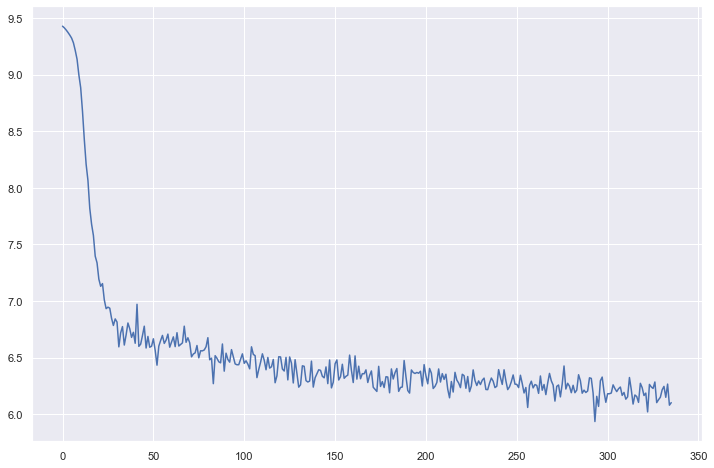

  0%|                                                                                           | 0/42 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
hyperparams = Hyperparams(embed_size=250, hidden_size=250, num_layers=3,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.0005, optimizer=optim.Adam, batch_size=250)

dataloader, model, optimizer, criterion = initialize_data_model_optim_loss(hyperparams)

train(10, dataloader, model, criterion, optimizer)

In [21]:
for _ in range(20):
    generate_example(model)

<s> lol i thru paiseh go not gave got jelly , . </s>
<s> . </s>
<s> u jeff people 're god ) i gp u < ! </s>
<s> hey submission minute stuff nid company na know , and yo ? </s>
<s> i aa wazup r ? </s>
<s> come to nxt . </s>
<s> : coz are go . </s>
<s> think hahaha your aiyo you of wun say doing up to mean easy to at . </s>
<s> good far yup then right . </s>
<s> dunno ! </s>
<s> sure do to free ? </s>
<s> we ! </s>
<s> ms go ur reciev free at kk.. like dildaaron lol all my bet manau of dear ? </s>
<s> i to breeze bao - ur 2 frnkly tt n't lah mah ... . </s>
<s> m in at she front p . </s>
<s> tml . </s>
<s> now.. hv my . </s>
<s> nvr just soon high god level real before bhai.. brush time i prayer ... press meet ? </s>
<s> man best wan movie u bhi was ring like down late nuggets ... round ... ohh and haha u my . </s>
<s> hahaha lah think u u morn anot lol know how clothes did liao 're - next you.. : r ! </s>


In [22]:
import json
torch.save(model.state_dict(), 'gru-model-singlish.pth')

hyperparams_str = Hyperparams(embed_size=250, hidden_size=250, num_layers=3,
                          loss_func='nn.CrossEntropyLoss',
                          learning_rate=0.0005, optimizer='optim.Adam', batch_size=250)

with open('gru-model-singlish.json', 'w') as fout:
    json.dump(dict(hyperparams_str._asdict()), fout)